# Basurales: Entrenamiento



# Entrenamiento  

 ### Sentinel-2 rgb nir swir diffSW

Las librerías que importamos nos permite acceder a las herramientas que vamos a utilizar a lo largo del proyecto como por ejemplo la función de train y predict  del modelo de Unet.

In [1]:
from basurales.unet.train import TrainConfig, train
from basurales.unet.evaluate import plot_data_generator
import os

/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/

En esta etapa debemos definir la configuración del modelo de ML


In [2]:
config = TrainConfig(width=160,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=160,
                     n_channels=6,  #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=20, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=16, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=200, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=5, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento
                     images_path=os.path.join('/home/ro/basurales/data/data_train','6D', '100_30'), #ruta a las imágenes
                     model_path=os.path.join('/home/ro/basurales/data/weights/', 'UNet_basurales_6D_100_30_spe200_.h5'),#  ruta al archivo de entrenamiento
                     evaluate=False  ,
                     weights= [0.8]) 

In [ ]:
!ls ./../

Podemos visualizar alguna de las imágenes y máscaras.

0000027136-0000054272_rgb-nir-sw-diffSW_413_30.tif


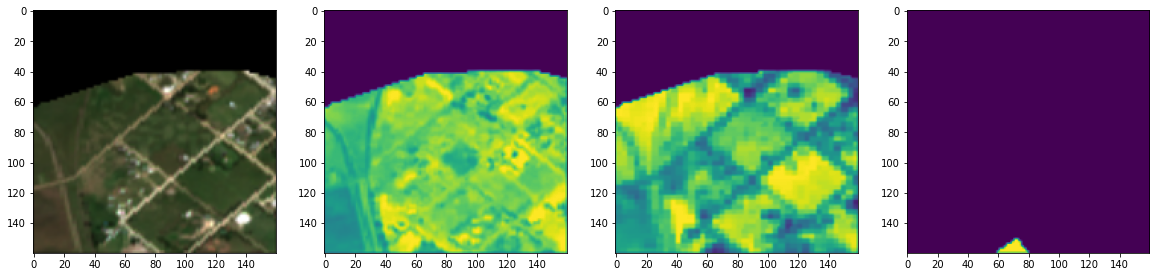

0000000000-0000040704_rgb-nir-sw-diffSW_445_25.tif


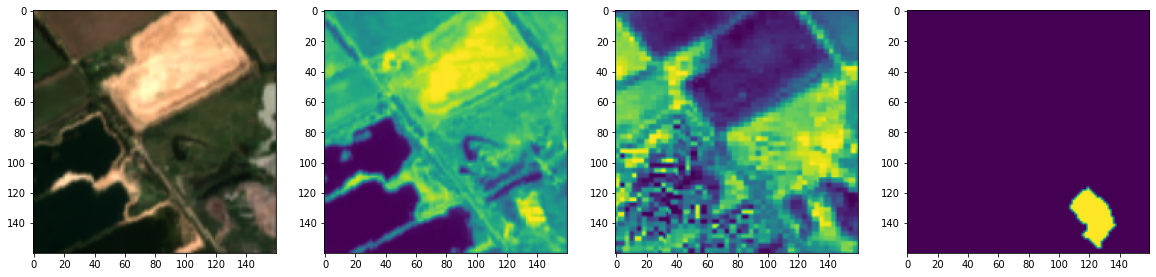

0000000000-0000013568_rgb-nir-sw-diffSW_220_181.tif


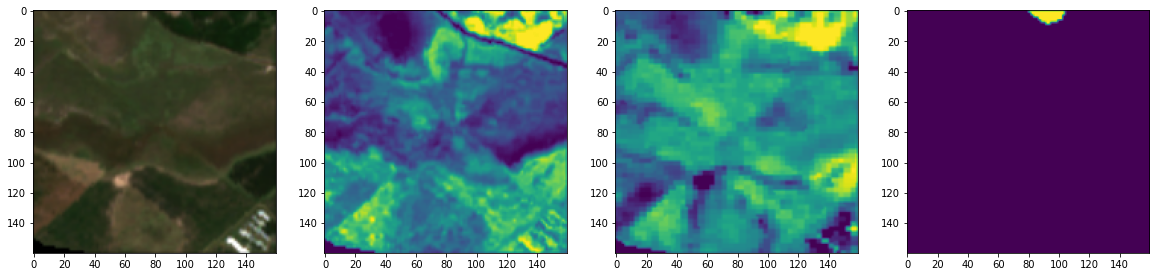

0000013568-0000013568_rgb-nir-sw-diffSW_331_280.tif


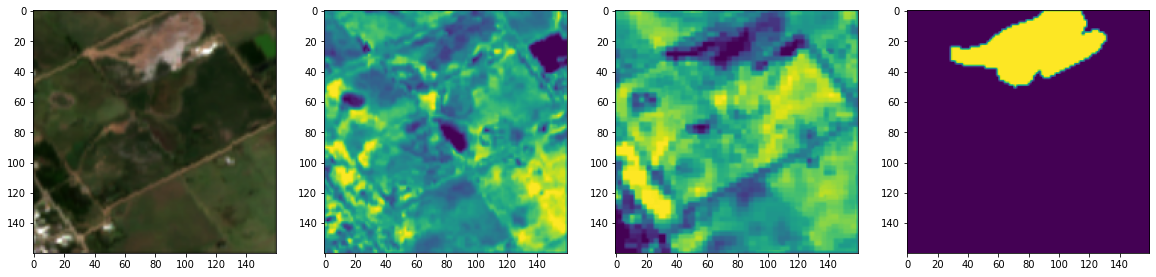

0000000000-0000027136_rgb-nir-sw-diffSW_53_127.tif


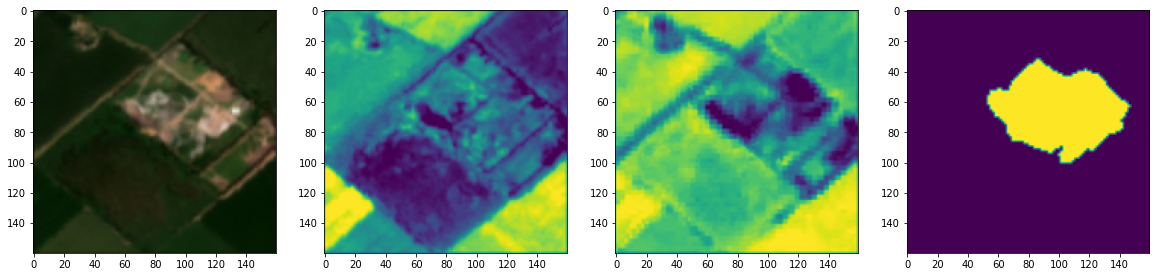

0000000000-0000027136_rgb-nir-sw-diffSW_53_129.tif


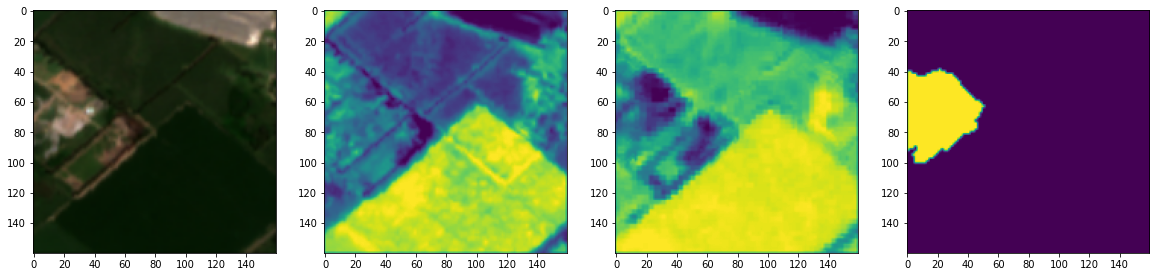

0000013568-0000013568_rgb-nir-sw-diffSW_172_227.tif


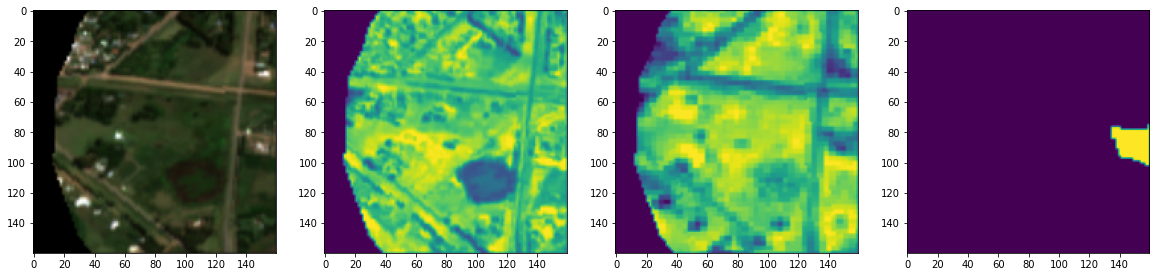

0000000000-0000013568_rgb-nir-sw-diffSW_330_345.tif


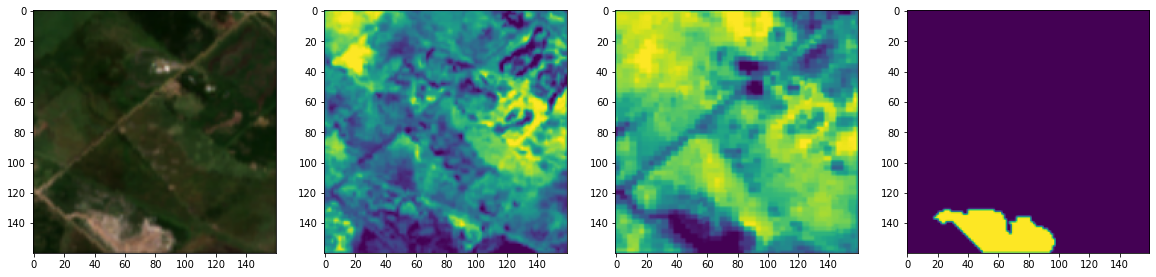

0000000000-0000027136_rgb-nir-sw-diffSW_347_359.tif


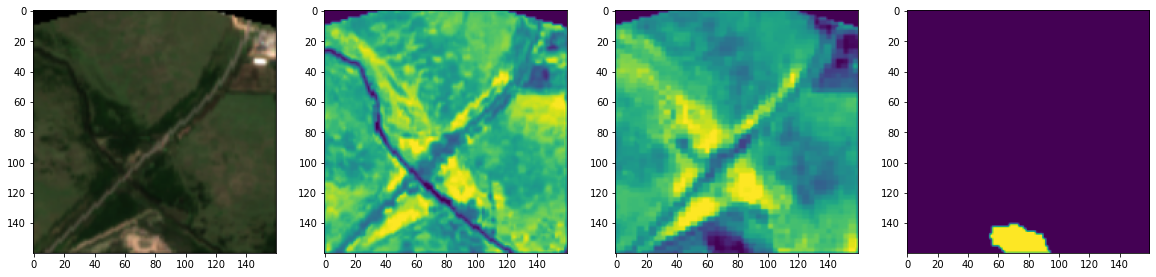

0000000000-0000013568_rgb-nir-sw-diffSW_217_180.tif


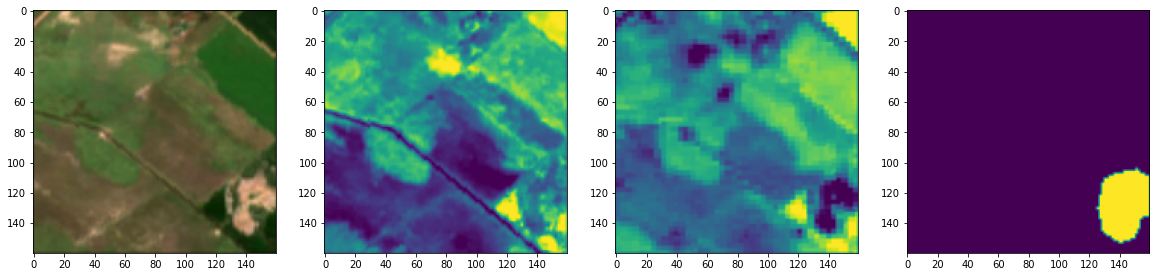

In [4]:
import tifffile as tiff
from skimage.transform import resize
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import random
import numpy as np
from glob import glob
import os
H=10

config_s2=config
images = [os.path.basename(f) for f in sorted(glob(os.path.join(config_s2.images_path,'images', '*.tif')))]

# Sample
#images = images[:H] 
images = random.sample(images, H)
for img_file in images:
    try:
        #s2 3D
        img_s2 = tiff.imread(os.path.join(config_s2.images_path, 'images', img_file))[:,:,:3]
        img_s2 = minmax_scale(img_s2.ravel(), feature_range=(0, 255)).reshape(img_s2.shape)
        img_s2 = resize(img_s2, (config_s2.height, config_s2.width), mode='constant', preserve_range=True).astype(np.uint8)
        #S2 NIR
        img_s2nir = tiff.imread(os.path.join(config_s2.images_path, 'images', img_file))[:,:,3]
        img_s2nir = minmax_scale(img_s2nir.ravel(), feature_range=(0, 255)).reshape(img_s2nir.shape)
        img_s2nir = resize(img_s2nir, (config_s2.height, config_s2.width), mode='constant', preserve_range=True).astype(np.uint8)
        #S2 SWIR
        img_s2swir = tiff.imread(os.path.join(config_s2.images_path, 'images', img_file))[:,:,5]
        img_s2swir = minmax_scale(img_s2swir.ravel(), feature_range=(0, 255)).reshape(img_s2swir.shape)
        img_s2swir = resize(img_s2swir, (config_s2.height, config_s2.width), mode='constant', preserve_range=True).astype(np.uint8)
       
        mask = tiff.imread(os.path.join(config_s2.images_path, 'masks', img_file))
        mask = minmax_scale(mask.ravel(), feature_range=(0, 255)).reshape(mask.shape)
        mask = resize(mask, (config_s2.height, config_s2.width), mode='constant', preserve_range=True).astype(np.uint8)
       
    
        print(img_file)
       
        fig, axes = plt.subplots(nrows=1, ncols=4 , figsize=(20, 40)) 
        
        axes[0].imshow(img_s2)
        axes[1].imshow(img_s2nir)
        axes[2].imshow(img_s2swir)
        axes[3].imshow(np.squeeze(mask))
        
        plt.show()
        print("=================================================================================")
    except Exception as err:
        print(err)

Ejecuta el entrenamiento.

In [3]:
res_config = train(config)


Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 6)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 1760        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 160, 160, 32) 9248        conv2d_1[0][0]                   
_________________________________________________________________


Epoch 1/20
200/200 [==============================] - 71s 357ms/step - loss: 0.1317 - accuracy: 0.9443 - iou: 0.1070 - mean_iou: 0.4837 - val_loss: 0.1161 - val_accuracy: 0.9398 - val_iou: 0.1566 - val_mean_iou: 0.4970

Epoch 00001: val_loss improved from inf to 0.11613, saving model to /home/ro/basurales/data/weights/UNet_basurales_6D_100_30_spe200_.h5
Epoch 2/20
200/200 [==============================] - 75s 376ms/step - loss: 0.0818 - accuracy: 0.9575 - iou: 0.1821 - mean_iou: 0.5105 - val_loss: 0.0873 - val_accuracy: 0.9585 - val_iou: 0.2881 - val_mean_iou: 0.5315

Epoch 00002: val_loss improved from 0.11613 to 0.08733, saving model to /home/ro/basurales/data/weights/UNet_basurales_6D_100_30_spe200_.h5
Epoch 3/20
200/200 [==============================] - 67s 336ms/step - loss: 0.0652 - accuracy: 0.9651 - iou: 0.2426 - mean_iou: 0.5511 - val_loss: 0.1279 - val_accuracy: 0.9612 - val_iou: 0.2306 - val_mean_iou: 0.5651

Epoch 00003: val_loss did not improve from 0.08733
Epoch 4/20
2

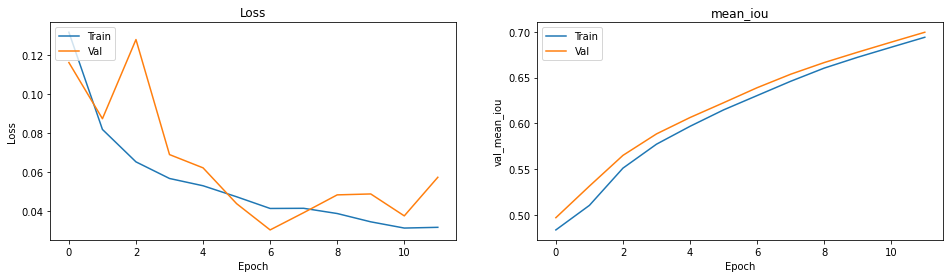

In [4]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_iou'])
plt.plot(res_config.history['val_mean_iou'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()